In [1]:
%matplotlib inline
from importlib import reload
import utils; reload(utils)
from utils import *

Using Theano backend.


In [2]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import datetime
import multiprocessing as mp
import pickle
from functools import reduce

from skimage import measure, morphology, color
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Set constants

In [3]:
# Some constants 
data_root = '/Users/szalmaf/Documents/GitHub/Training Python/Kaggle_Data_Science_Bowl_2017/'

# Read in data

In [4]:
labeledImgs = load_array(data_root + 'images_3d_array-1397x64x224x224.bc')

In [4]:
labeledImgs = load_array(data_root + 'images_3d_array-300x64x224x224.bc')

In [5]:
save_array(arr=labeledImgs[:300], fname=data_root + 'images_3d_array-300x64x224x224.bc')

In [9]:
labeledPatients = pd.read_csv(data_root + 'labeled_patients_labels100.csv')

In [29]:
# labeledPatients[:100].to_csv(data_root + 'labeled_patients_labels100.csv', index=False)

# Set up trn and val sets

In [10]:
from sklearn.model_selection import train_test_split

In [ ]:
trn,val = train_test_split(labeledImgs, test_size=0.2, random_state=42)

In [32]:
labeledImgs.nbytes

642252800

In [33]:
del labeledImgs

In [11]:
labels = to_categorical(np.array(np.int32(labeledPatients['cancer'])))
trn_labels, val_labels = train_test_split(labels, test_size=0.2, random_state=42)

In [13]:
val_labels

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.]])

# Set up model

## Load VGG16, compile, and fit it. Save results

In [5]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(2)

/Users/szalmaf/anaconda/envs/kaggle2017/lib/python3.5/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [7]:
model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [8]:
trn3 = labeledImgs.reshape(-1, labeledImgs.shape[2], labeledImgs.shape[3]) 
trn3.shape

(19200, 224, 224)

In [13]:
# trn1 =  np.transpose(np.transpose(trn, [1,2,3,0])[31], [2,0,1]) # Pick 31st layer of each patient's image
# val1 = np.transpose(np.transpose(val, [1,2,3,0])[31], [2,0,1]) # Pick 31st layer of each patient's image

In [15]:
trn3 = trn.reshape(-1, trn.shape[2], trn.shape[3])

In [9]:
trn3.shape

(19200, 224, 224)

In [42]:
val3 = val.reshape(-1, val.shape[2], val.shape[3])

In [9]:
def fn(x): return np.transpose(color.gray2rgb(x), [2,0,1])

In [11]:
val3.nbytes

NameError: name 'val3' is not defined

In [ ]:
# skip = val3.shape[0]/10
# val2 = np.zeros()
# for n in range(0, val3.shape[0], skip)
#     val = val3[n:n+skip]
#     val1 = np.array(map(fn, val))
#     val2 = 

In [45]:
%time val2 = np.stack(map(fn, val3))

CPU times: user 387 ms, sys: 280 ms, total: 667 ms
Wall time: 704 ms


In [10]:
%time trn2 = np.stack(map(fn, trn3))

CPU times: user 4.62 s, sys: 10.8 s, total: 15.4 s
Wall time: 19.2 s


In [11]:
trn2.shape

(19200, 3, 224, 224)

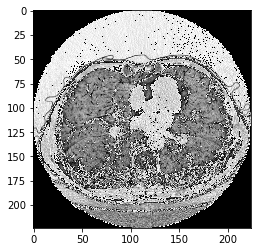

In [12]:
im = trn2[31]
im.shape
plt.imshow(np.transpose(im, [1,2,0]))

In [26]:
batch_size = 8

In [31]:
model.fit(trn2, 
          trn_labels, 
          batch_size=batch_size, 
          nb_epoch=1, 
          validation_data=(val2, val_labels))

Train on 1117 samples, validate on 280 samples
Epoch 1/1
1117/1117 [==============================] - 691s - loss: 2.0200 - acc: 0.6204 - val_loss: 1.3840 - val_acc: 0.6500

In [33]:
model.save_weights(data_root+'results/ft1.h5')

## Pre-compute last conv layer in VGG

In [14]:
model.load_weights(data_root + 'results/ft1.h5')

NameError: name 'model' is not defined

In [13]:
conv_layers,fc_layers = split_at(model, Convolution2D)

In [14]:
conv_model = Sequential(conv_layers)

In [51]:
%time conv_val_feat = conv_model.predict(val2)

CPU times: user 37min 21s, sys: 1min 26s, total: 38min 47s
Wall time: 10min 20s


In [55]:
conv_val_feat.shape

(1280, 512, 14, 14)

In [15]:
%time conv_feat = conv_model.predict(trn2)

CPU times: user 9h 24min 30s, sys: 21min 53s, total: 9h 46min 23s
Wall time: 2h 35min 27s


In [56]:
conv_val_feat2 = conv_val_feat.reshape(val.shape[0], val.shape[1], conv_val_feat.shape[-3], conv_val_feat.shape[-2], conv_val_feat.shape[-1])

In [57]:
conv_val_feat2.shape

(20, 64, 512, 14, 14)

In [59]:
save_array(data_root+'results/conv_val_feat.dat', conv_val_feat2)

In [17]:
conv_feat2 = conv_feat.reshape(labeledImgs.shape[0], labeledImgs.shape[1], conv_feat.shape[-3], conv_feat.shape[-2], conv_feat.shape[-1])

In [23]:
type(conv_feat2[0][0][0][0][0])

numpy.float32

In [20]:
save_array(data_root+'results/conv_feat_all.dat', conv_feat2)

## Train 3-layer fully connected z-direction 1d nn

In [7]:
conv_feat = load_array(data_root + 'results/conv_feat.dat')
conv_val_feat = load_array(data_root + 'results/conv_val_feat.dat')

In [8]:
conv_feat.shape, conv_val_feat.shape

((80, 64, 512, 14, 14), (20, 64, 512, 14, 14))

In [9]:
conv_val_feat1d = np.mean(conv_val_feat, axis=(3,4))
conv_feat1d = np.mean(conv_feat, axis=(3,4))

In [12]:
conv_val_feat1d.shape, conv_feat1d.shape

((20, 64, 512), (80, 64, 512))

In [42]:
p=1.
model_z = Sequential([
    Conv1D(filter_length=3, nb_filter=512, input_shape=(64, 512), activation="relu", border_mode="same"),
    BatchNormalization(),
    MaxPooling1D(),
    Conv1D(256, 3, activation="relu", border_mode="same"),
    BatchNormalization(),
    MaxPooling1D(),
    Conv1D(128, 3, activation="relu", border_mode="same"),    
    BatchNormalization(),
    MaxPooling1D(),
    Conv1D(2, 3, border_mode="same"),
    GlobalAveragePooling1D(),
    ])


In [43]:
model_z.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_22 (Convolution1D) (None, 64, 512)       786944      convolution1d_input_5[0][0]      
____________________________________________________________________________________________________
batchnormalization_17 (BatchNorm (None, 64, 512)       2048        convolution1d_22[0][0]           
____________________________________________________________________________________________________
maxpooling1d_17 (MaxPooling1D)   (None, 32, 512)       0           batchnormalization_17[0][0]      
____________________________________________________________________________________________________
convolution1d_23 (Convolution1D) (None, 32, 256)       393472      maxpooling1d_17[0][0]            
___________________________________________________________________________________________

In [37]:
model_z.compile(Adam(lr=0.0001), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

In [39]:
model_z.fit(conv_feat1d, 
             trn_labels, 
             batch_size=8, 
             nb_epoch=100, 
             validation_data=(conv_val_feat1d, val_labels))

Train on 80 samples, validate on 20 samples
Epoch 1/100
80/80 [==============================] - 1s - loss: 1.5666 - acc: 0.4250 - val_loss: 0.5478 - val_acc: 0.2000
Epoch 2/100
80/80 [==============================] - 1s - loss: 2.3510 - acc: 0.4375 - val_loss: 2.1206 - val_acc: 0.4000

# 2D CNN + 1D Convnet or 2D CNN + 1D LSTM

Pipeline:
• Input original images (orig size?)
• Affine transform images
• Any-sized input VGG from fast.ai or resnet50
• Output ~512x7x7 feature set, flatten it
• 1D Convnet or (one-directional) LSTM (reset at "end" of image) 

In [ ]:
# Load images

In [24]:
# Rotate images

In [12]:
# Fast.ai Lesson 7 1:04:28
# Load VGG16 for any input size
from vgg16bn import Vgg16BN
vgg512 = Vgg16BN((512,512)).model

/Users/szalmaf/anaconda/envs/kaggle2017/lib/python3.5/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_6 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 512, 512)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [13]:
vgg512.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_6 (Lambda)                (None, 3, 512, 512)   0           lambda_input_6[0][0]             
____________________________________________________________________________________________________
zeropadding2d_66 (ZeroPadding2D) (None, 3, 514, 514)   0           lambda_6[0][0]                   
____________________________________________________________________________________________________
convolution2d_66 (Convolution2D) (None, 64, 512, 512)  1792        zeropadding2d_66[0][0]           
____________________________________________________________________________________________________
zeropadding2d_67 (ZeroPadding2D) (None, 64, 514, 514)  0           convolution2d_66[0][0]           
___________________________________________________________________________________________

In [14]:
vgg512.pop()

In [15]:
vgg512.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_6 (Lambda)                (None, 3, 512, 512)   0           lambda_input_6[0][0]             
____________________________________________________________________________________________________
zeropadding2d_66 (ZeroPadding2D) (None, 3, 514, 514)   0           lambda_6[0][0]                   
____________________________________________________________________________________________________
convolution2d_66 (Convolution2D) (None, 64, 512, 512)  1792        zeropadding2d_66[0][0]           
____________________________________________________________________________________________________
zeropadding2d_67 (ZeroPadding2D) (None, 64, 514, 514)  0           convolution2d_66[0][0]           
___________________________________________________________________________________________

In [16]:
vgg512.input_shape, vgg512.output_shape

((None, 3, 512, 512), (None, 512, 32, 32))

In [20]:
vgg512.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
val_feat = vgg512.predict(val, batch_size=32, verbose=1)
trn_feat = vgg512.predict(trn, batch_size=32, verbose=1)

In [21]:
vgg_conv_layers,_ = split_at(vgg512, Convolution2D)

In [24]:
p = 0.
def transfer_layers(n):
    return [
        BatchNormalization(axis=1, input_shape=vgg_conv_layers[-1].output_shape[1:]),
        Convolution2D(512,3,3,activation='relu',border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(512,3,3,activation='relu',border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(512,3,3,activation='relu',border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Dropout(p),
    ]

In [25]:
model_trf = Sequential(transfer_layers())

In [26]:
model_trf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 512, 32, 32)   2048        batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_79 (Convolution2D) (None, 512, 32, 32)   2359808     batchnormalization_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_2 (BatchNorma (None, 512, 32, 32)   2048        convolution2d_79[0][0]           
____________________________________________________________________________________________________
maxpooling2d_31 (MaxPooling2D)   (None, 512, 16, 16)   0           batchnormalization_2[0][0]       
___________________________________________________________________________________________

In [17]:
!git add image3d-vgg.ipynb

In [18]:
!git commit -m "Add 2D CNN + 1D Convnet or 2D CNN + 1D LSTM"

[master c4cbee2] Add 2D CNN + 1D Convnet or 2D CNN + 1D LSTM
 1 file changed, 475 insertions(+), 98 deletions(-)


In [19]:
!git push origin master

Counting objects: 3, done.
Delta compression using up to 8 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 96.74 KiB | 0 bytes/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
remote: This repository moved. Please use the new location:
remote:   git@github.com:szalmaf/Linear_regression_to_Deep_Learning_in_Keras.git
To github.com:szalmaf/Linear_regression_in_Keras.git
   82687c4..c4cbee2  master -> master
